In [1]:
#@title
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#@title
datasets = {'ml100k':'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
            'ml20m':'http://files.grouplens.org/datasets/movielens/ml-20m.zip',
            'mllatestsmall':'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
            'ml10m':'http://files.grouplens.org/datasets/movielens/ml-10m.zip',
            'ml1m':'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
            }

In [42]:
print('Available datasets: ', [key for key in datasets])
dt = input('Dataset name = ')
print('You selected {}'.format(dt))

Available datasets:  ['ml100k', 'ml20m', 'mllatestsmall', 'ml10m', 'ml1m']
Dataset name = ml1m
You selected ml1m


In [43]:
dt_name = os.path.basename(datasets[dt])

print('Downloading {}'.format(dt_name))
with urllib.request.urlopen(datasets[dt]) as response, open('./sample_data/'+dt_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print('Download completed')

Download completed


In [44]:
with zipfile.ZipFile('./sample_data/'+dt_name, 'r') as zip_ref:
    zip_ref.extractall('./sample_data/')
dt_dir_name = os.path.splitext(dt_name)[0]

In [45]:
#Check unzipped structure
def list_files(startpath):
    print(startpath)
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
dirs = [x[0] for x in os.walk("./sample_data")]
#print(list(dirs[0]))
ml = filter(lambda dirName: dirName if ('ml' in dirName) else '', list(dirs))
dt_dir_name= list(ml)[0]
print(dt_dir_name)
#list_files('./sample_data/'+dt_dir_name +'/')

./sample_data/ml-1m


In [46]:
#100k
if dt == 'ml100k':
    dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))

#ml1m
if dt=='ml1m':
    dataset=pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])  
dataset.head()

user_id  item_id  rating  timestamp
0        1     1193       5  978300760
1        1      661       3  978302109
2        1      914       3  978301968
3        1     3408       4  978300275
4        1     2355       5  978824291

In [47]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(6040, 3706)

In [48]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [49]:
#Version 1.2 (flexible + superfast negative sampling uniform)
import random
import time
import scipy

def neg_sampling(ratings_df, n_neg=1, neg_val=0, pos_val=1, percent_print=5):
    """version 1.2: 1 positive 1 neg (2 times bigger than the original dataset by default)

    Parameters:
    input rating data as pandas dataframe: userId|movieId|rating
    n_neg: include n_negative / 1 positive

    Returns:
    negative sampled set as pandas dataframe
            userId|movieId|interact (implicit)
    """
    sparse_mat = scipy.sparse.coo_matrix((ratings_df.rating, (ratings_df.user_id, ratings_df.item_id)))
    dense_mat = np.asarray(sparse_mat.todense())
    print(dense_mat.shape)

    nsamples = ratings_df[['user_id', 'item_id']]
    nsamples['rating'] = nsamples.apply(lambda row: 1, axis=1)
    length = dense_mat.shape[0]
    printpc = int(length * percent_print/100)

    nTempData = []
    i = 0
    start_time = time.time()
    stop_time = time.time()

    extra_samples = 0
    for row in dense_mat:
        if(i%printpc==0):
            stop_time = time.time()
            print("processed ... {0:0.2f}% ...{1:0.2f}secs".format(float(i)*100 / length, stop_time - start_time))
            start_time = stop_time

        n_non_0 = len(np.nonzero(row)[0])
        zero_indices = np.where(row==0)[0]
        if(n_non_0 * n_neg + extra_samples > len(zero_indices)):
            print(i, "non 0:", n_non_0,": len ",len(zero_indices))
            neg_indices = zero_indices.tolist()
            extra_samples = n_non_0 * n_neg + extra_samples - len(zero_indices)
        else:
            neg_indices = random.sample(zero_indices.tolist(), n_non_0 * n_neg + extra_samples)
            extra_samples = 0

    nTempData.extend([(uu, ii, rr) for (uu, ii, rr) in zip(np.repeat(i, len(neg_indices))
                    , neg_indices, np.repeat(neg_val, len(neg_indices)))])
    i+=1

    nsamples=nsamples.append(pd.DataFrame(nTempData, columns=["user_id","item_id", "rating"]),ignore_index=True)
    nsamples.reset_index(drop=True)
    return nsamples

In [50]:
neg_dataset = neg_sampling(dataset)


train, test = train_test_split(neg_dataset, test_size=0.2, random_state=2020)
train, val = train_test_split(train, test_size=0.2, random_state=2020)


(6040, 3706)
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processe

In [51]:
print(neg_dataset.shape, train.shape, test.shape, val.shape)

(1000550, 3) (640352, 3) (200110, 3) (160088, 3)


In [52]:
print(train.shape,"\n", train.head())

(640352, 3) 
         user_id  item_id  rating
199154     1222     1008       1
497065     3053      862       1
187428     1163     2775       1
423946     2567     2143       1
126839      817     2263       1


In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.initializers import RandomUniform, he_normal,he_uniform
import math

In [54]:
model_name='model1'
seed=2020
embedding_init = RandomUniform(seed=seed)
relu_init = he_uniform(seed=seed)
embeddings_regu =l2(1e-6)

In [55]:
def create_model(dataset, n_latent_factors = 16):
    n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
    n_latent_factors = 16

    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies, n_latent_factors, 
                                          embeddings_initializer=embedding_init, 
                                          embeddings_regularizer=embeddings_regu, 
                                          embeddings_constraint="NonNeg", 
                                          name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_embedding = keras.layers.Embedding(n_users, n_latent_factors, 
                                          embeddings_initializer=embedding_init, 
                                          embeddings_regularizer=embeddings_regu, 
                                          embeddings_constraint="NonNeg", 
                                          name='User-Embedding')(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

    prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='DotProduct')
    model = keras.Model([user_input, movie_input], prod)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
    model.summary()
    return model

In [56]:
model = create_model(neg_dataset) 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 16)        59296       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 16)        96640       User[0][0]                       
____________________________________________________________________________________________

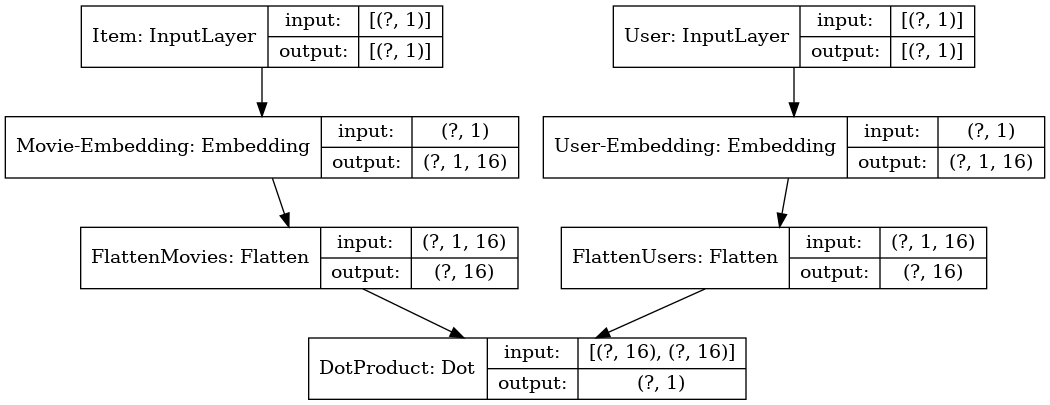

In [57]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [58]:
neg_dataset.isna().any()

user_id    False
item_id    False
rating     False
dtype: bool

In [59]:
np.isnan(neg_dataset.loc[[x for x in range(100000)], ['user_id']].to_numpy()).any()

False

In [60]:
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, shuffle=False):
        'Initialization'
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.shuffle = shuffle
        self.indices = dataframe.index
        print(len(self.indices),"\n", dataframe.isna().any())
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.floor(len(self.dataframe) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]
        
        # Find list of batch IDs
        list_IDs_temp = [self.indices[k] for k in idxs]

        # Generate data
        User = self.dataframe.iloc[list_IDs_temp,[0]].to_numpy().reshape(-1)
        Item = self.dataframe.iloc[list_IDs_temp,[1]].to_numpy().reshape(-1)
        rating = self.dataframe.iloc[list_IDs_temp,[2]].to_numpy().reshape(-1)
        assert(np.isnan(User).any(), User)
        assert(np.isnan(Item).any(), Item)
        assert(np.isnan(rating).any(), rating)
        #print(idxs, '\n', "u,i,", [User, Item],'\n',[rating])
        return [User, Item],[rating]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:
#2  training with fit generator
train_generator = DataGenerator(train, batch_size=256, shuffle=False)
#val_generator = DataGenerator(val, batch_size=256, shuffle=False)
history = model.fit(train_generator, epochs=150, verbose=2)

640352 
 user_id    False
item_id    False
rating     False
dtype: bool
Epoch 1/50
2501/2501 - 12s - loss: 0.2327 - binary_accuracy: 0.8900
Epoch 2/50
2501/2501 - 12s - loss: 0.2271 - binary_accuracy: 0.8935
Epoch 3/50
2501/2501 - 12s - loss: 0.2218 - binary_accuracy: 0.8968
Epoch 4/50
2501/2501 - 12s - loss: 0.2167 - binary_accuracy: 0.9001
Epoch 5/50
2501/2501 - 12s - loss: 0.2117 - binary_accuracy: 0.9031
Epoch 6/50
2501/2501 - 12s - loss: 0.2069 - binary_accuracy: 0.9061
Epoch 7/50
2501/2501 - 12s - loss: 0.2023 - binary_accuracy: 0.9088
Epoch 8/50
2501/2501 - 12s - loss: 0.1979 - binary_accuracy: 0.9116
Epoch 9/50
2501/2501 - 12s - loss: 0.1936 - binary_accuracy: 0.9142
Epoch 10/50
2501/2501 - 12s - loss: 0.1895 - binary_accuracy: 0.9165
Epoch 11/50
2501/2501 - 12s - loss: 0.1855 - binary_accuracy: 0.9188
Epoch 12/50
2501/2501 - 12s - loss: 0.1816 - binary_accuracy: 0.9211
Epoch 13/50
2501/2501 - 12s - loss: 0.1779 - binary_accuracy: 0.9234
Epoch 14/50
2501/2501 - 12s - loss: 0.17

In [24]:
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['binary_accuracy']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','binary_accuracy'])

In [27]:
results = model.evaluate((test.user_id, test.item_id), test.rating,
                            batch_size=16)

1253/1253 [==============================] - 1s 966us/step - loss: 2.6432 - binary_accuracy: 0.0022


In [28]:
print(results)

[2.6431643962860107, 0.0021962663158774376]


In [30]:
y_hat = model.predict([test.user_id, test.item_id])
y_true = test.rating

In [31]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.9178829136943708

In [32]:
tmp_lst_u=train.user_id.unique()
tmp_lst_i=train.item_id.unique()
tmp_lst_u.sort(), tmp_lst_i.sort()
lst_user=tmp_lst_u.tolist()
lst_item=tmp_lst_i.tolist()


In [33]:
def Top_100_Unused_item(user_id):
    tmp_df_used_item=train.loc[(train['user_id']==user_id) & (train['rating']==1)]
    tmp_lst=tmp_df_used_item['item_id'].values.tolist()
    #lst_un_item= set(lst_item) - set(tmp_lst)
    lst_un_item=[x for x in lst_item if x not in tmp_lst]
    
    #random 100 items:
    tmp_no=100
    lst_100_un_item=(np.random.choice(lst_un_item,tmp_no))
    
    
    #Create DataFrame
    tmp_df=pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'prediction'])
    tmp_df['item_id']=lst_100_un_item
    tmp_df['user_id']=user_id
    tmp_df['rating']=0.0

    y_hat = model.predict([tmp_df.user_id, tmp_df.item_id])
    tmp_arr=y_hat.flatten().tolist()
    tmp_df['prediction']=tmp_arr
    return tmp_df

In [34]:
Top_100_Unused_item(0)

user_id  item_id  rating  prediction
0         0      710     0.0    0.026858
1         0     1332     0.0    0.032401
2         0     1428     0.0    0.020083
3         0      923     0.0    0.080258
4         0     1486     0.0    0.020225
..      ...      ...     ...         ...
95        0      255     0.0    0.031931
96        0      511     0.0    0.063367
97        0     1625     0.0    0.021659
98        0      136     0.0    0.113328
99        0     1134     0.0    0.057696

[100 rows x 4 columns]

In [35]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

0            1            2            3            4   \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean      0.038362     0.039120     0.040330     0.039403     0.039099   
std       0.045859     0.034244     0.036223     0.028551     0.028948   
min      -0.000000    -0.000000    -0.000000    -0.000000    -0.000000   
25%       0.014464     0.014798     0.014476     0.015353     0.014913   
50%       0.033337     0.034279     0.035498     0.035096     0.035255   
75%       0.054793     0.056566     0.058157     0.056336     0.056475   
max       1.530693     0.792582     0.882523     0.148841     0.157399   

                5            6            7            8            9   \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean      0.037717     0.039562     0.037250     0.037200     0.038599   
std       0.027753     0.070173     0.038328     0.027661     0.033750   
min      -0.000000    -0.000000    -0.000000    -0.000000    -0.000000   
25%       0.014540     0.014149     0.014664     0.013581     0.014429   
50%       0.033201     0.034388     0.033466     0.033274     0.034170   
75%       0.054549     0.055169     0.052704     0.053422     0.054891   
max       0.142810     2.680617     1.151878     0.149315     0.813423   

                10           11           12           13           14  \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean      0.041081     0.036585     0.038655     0.040627     0.037322   
std       0.076854     0.026560     0.030519     0.030127     0.030285   
min      -0.000000    -0.000000    -0.000000    -0.000000    -0.000000   
25%       0.016264     0.014378     0.014647     0.015607     0.013349   
50%       0.034369     0.032853     0.034467     0.036268     0.033407   
75%       0.055900     0.053298     0.056008     0.059687     0.054612   
max       2.956061     0.142901     0.424430     0.157900     0.545147   

                15  
count  1682.000000  
mean      0.040162  
std       0.029276  
min      -0.000000  
25%       0.016352  
50%       0.035900  
75%       0.057155  
max       0.164552

In [36]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

0           1           2           3           4           5   \
count  943.000000  943.000000  943.000000  943.000000  943.000000  943.000000   
mean     0.052417    0.054410    0.056649    0.055104    0.055656    0.055759   
std      0.027723    0.030271    0.029312    0.029570    0.039654    0.088690   
min      0.008217    0.001252    0.001323    0.001288    0.001204    0.010427   
25%      0.029323    0.029049    0.031828    0.030706    0.030875    0.030142   
50%      0.048347    0.050685    0.052976    0.051213    0.051916    0.049802   
75%      0.070859    0.075070    0.076062    0.074230    0.071815    0.069989   
max      0.168817    0.271759    0.149636    0.181229    0.873880    2.640762   

               6           7           8           9           10          11  \
count  943.000000  943.000000  943.000000  943.000000  943.000000  943.000000   
mean     0.053415    0.050866    0.053335    0.053904    0.055532    0.051210   
std      0.028359    0.026049    0.027669    0.028291    0.028186    0.026882   
min      0.008842    0.008553    0.009907    0.010210    0.008852    0.003331   
25%      0.030262    0.030342    0.031444    0.030498    0.032723    0.028734   
50%      0.049783    0.048229    0.050267    0.050265    0.052061    0.047954   
75%      0.071313    0.066984    0.069795    0.071840    0.074048    0.067109   
max      0.245640    0.166234    0.289736    0.206264    0.174137    0.224257   

               12          13          14          15  
count  943.000000  943.000000  943.000000  943.000000  
mean     0.054869    0.057675    0.054011    0.059292  
std      0.028369    0.030165    0.060291    0.077717  
min      0.001188    0.011238    0.009320    0.010646  
25%      0.032073    0.033364    0.028495    0.032948  
50%      0.050349    0.054282    0.048339    0.053761  
75%      0.072754    0.075567    0.069845    0.075577  
max      0.155324    0.165087    1.690508    2.280661

In [37]:
user_embedding_learnt

array([[0.08486652, 0.08576611, 0.08209303, ..., 0.1098879 , 0.08638124,
        0.08794932],
       [0.02845354, 0.08003442, 0.02999024, ..., 0.04255721, 0.0748041 ,
        0.0792421 ],
       [0.07499521, 0.03065588, 0.05221301, ..., 0.05904807, 0.04995047,
        0.03203668],
       ...,
       [0.01793054, 0.01574975, 0.01492849, ..., 0.01407094, 0.0137719 ,
        0.0161618 ],
       [0.03507077, 0.06481516, 0.0397773 , ..., 0.06445152, 0.04659226,
        0.03546529],
       [0.09393442, 0.06748163, 0.06059815, ..., 0.05930046, 0.06118818,
        0.05423501]], dtype=float32)

In [40]:
def recommend(user_id, number_of_movies=5):
    movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return mids

In [41]:
recommend(user_id=1)

array([293, 287,  49, 983, 839])